# Gradient boosting using power spectra

References:
* [LANL Earthquake EDA and Prediction](https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction/notebook)
* [LightGBM gradient boosting framework](https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMRegressor)
* [Energy spectra retrieving using FFT](https://www.kaggle.com/scaomath/lanl-earthquake-spectral-analysis-using-fft)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

In [3]:
%%time
train = pd.read_csv('../input/train.csv', 
                    dtype={'acoustic_data': np.int16, 
                           'time_to_failure': np.float32})

CPU times: user 2min 25s, sys: 31.1 s, total: 2min 56s
Wall time: 2min 56s


In [4]:
rows = 150000

num_segments = int(np.floor(train.shape[0] / rows))
dt = 0.0375/rows
# sampling_frequency is the upper bound of the frequency
sampling_frequency = np.ceil(1/dt)
print("Total {0:d} segments, time step {1:.1e} seconds, sampling frequency {2:0.0f} Mhz."\
      .format(num_segments, dt, sampling_frequency//1e6))

Total 4194 segments, time step 2.5e-07 seconds, sampling frequency 4 Mhz.


In [6]:
def get_spectrum(input_signal, window=100):
    """
    returns the Fourier power spectrum for a given signal segment
    output is a pandas Series 
    output.index is the frequencies
    output.values is the amplitudes for each frequencies
    default moving average window is 10
    """
    input_signal = np.asarray(input_signal.values, dtype='float32')
    
    # Remove the mean  
    input_signal -= input_signal.mean()  
    
    # Estimate power spectral density using a periodogram.
    frequencies , power_spectrum = signal.periodogram(
        input_signal, sampling_frequency, scaling='spectrum')    
    
    # Run a running windows average of 10-points to smooth the signal (default). 
    power_spectrum = pd.Series(power_spectrum, index=frequencies).rolling(window=window).mean()        
    
    return pd.Series(power_spectrum)

def get_segment_spectrum(segment_df, 
                         max_frequency = 300000, min_frequency = 100,
                         step = 10, window = 10):
    """
    get the Fourier power spectrum of a given segment.
    returns the quake_time, frequencies, and power_spectrum
    """
    
    quake_time = segment_df['time_to_failure'].values[-1]
    
    _power_spectrum = get_spectrum(segment_df['acoustic_data'], window=window).dropna() 
    # drop the null values

    # Keep only frequencies < max_frequency (larger frequencies have a negligible contribution).
    # and > min_frequency (some low frequency is outlier)
    _power_spectrum = _power_spectrum[_power_spectrum.index < max_frequency]
    _power_spectrum = _power_spectrum[_power_spectrum.index > min_frequency]
    
    # Keep one every 10 samples by default
    power_spectrum=_power_spectrum.values[::step]
    frequencies=_power_spectrum.index.values[::step]    
    
    return quake_time, frequencies, power_spectrum

In [7]:
## perform above for all segments
# since the frequencies retrieved is changing, initialization is none
window = 200
step = 5
quake_times = np.array([])       
power_spectrums = np.array([])
max_frequency = 350000
min_frequency = 0

for k in tqdm_notebook(range(num_segments)):
    segment = train.iloc[k*rows : k*rows+rows]
    quake_time, frequencies, power_spectrum = \
    get_segment_spectrum(segment, 
                         max_frequency=max_frequency,
                         min_frequency=min_frequency,
                         step=step,window=window)    
    quake_times = np.append(quake_times, quake_time)
    power_spectrums = np.append(power_spectrums, power_spectrum)
    
power_spectrums = power_spectrums.reshape(num_segments,-1)

In [8]:
X_train = power_spectrums/(np.sum(power_spectrums, axis=1)[:,np.newaxis])
X_train = pd.DataFrame(X_train)
y_train = quake_times

In [9]:
submission = pd.read_csv('../input/sample_submission.csv', 
                         index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, 
                      dtype=np.float64, 
                      index=submission.index)

In [10]:
for seg_id in tqdm_notebook(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    seg['time_to_failure'] = 0
    _, frequencies, seg_spectrum = \
    get_segment_spectrum(seg, 
                         max_frequency=max_frequency,
                         min_frequency=min_frequency,
                         step=step,window=window)
    X_test.loc[seg_id] = seg_spectrum/seg_spectrum.sum()

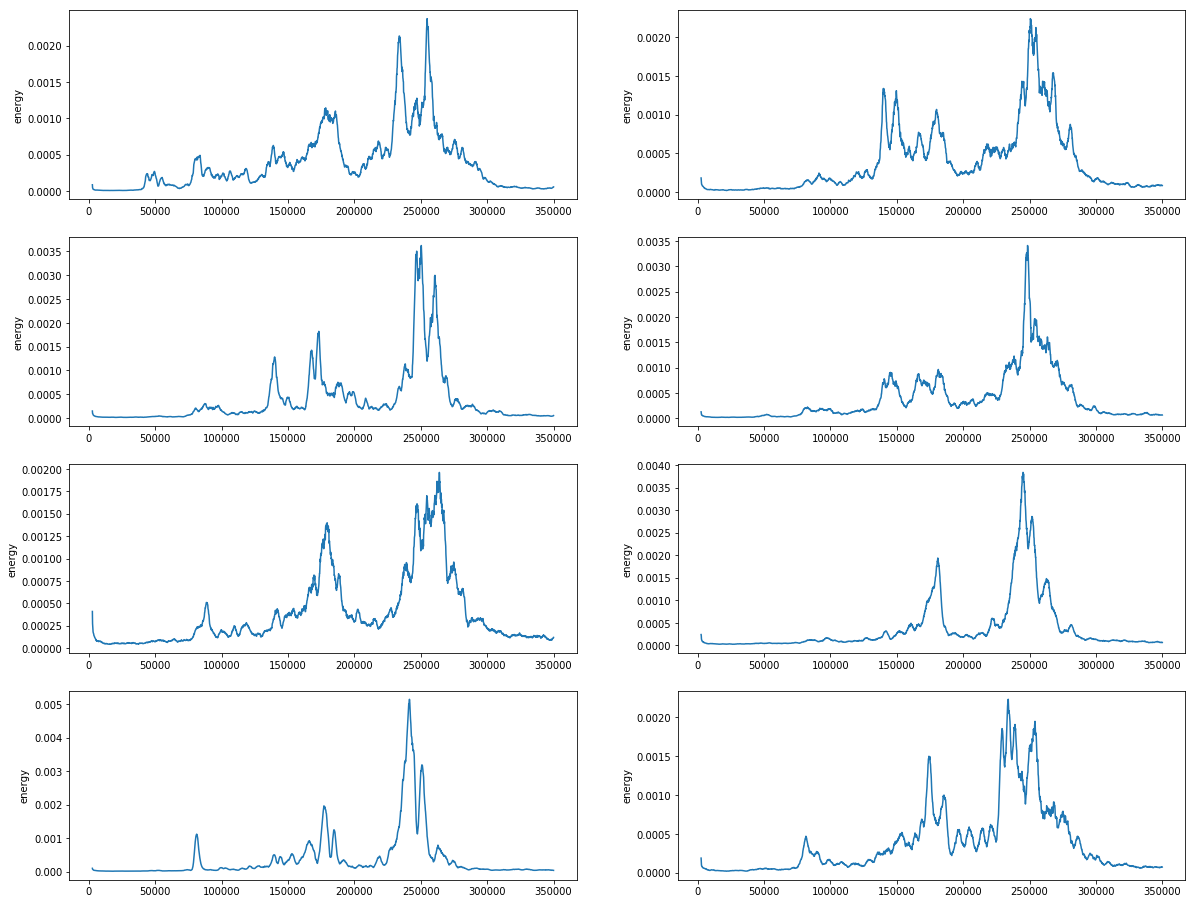

In [12]:
fig, ax = plt.subplots(4,2,figsize=(20,16))
ax = ax.reshape(-1)
idx = np.random.randint(1, X_train.shape[0]+1, size=8)
for i in range(8):
    ax[i].plot(frequencies,X_train.iloc[idx[i],:])
    ax[i].set_ylabel('Energy')

In [34]:
# averaging
window_freq = 10
X_tr_reduced = X_train.copy().groupby(X_train.columns // window_freq, axis=1).mean()
X_tst_reduced = X_test.copy().groupby(X_test.columns // window_freq, axis=1).mean()
frequencies = pd.Series(frequencies)
freq_reduced = frequencies.groupby(frequencies.index // window_freq).mean()

# LightGBM model

In [57]:
import lightgbm as lgb

params = {'num_leaves': 40,
         'min_data_in_leaf': 12, 
         'objective':'huber',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.95,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "lambda_l1": 0.6,
         "verbosity": -1,
         "nthread": -1}

In [36]:
from sklearn.model_selection import KFold

n_fold = 6
folds = KFold(n_splits=n_fold, shuffle=True, random_state=1127)

In [58]:
X_train = X_tr_reduced
X_test = X_tst_reduced
y_train = y_train.reshape(-1)
predictions = np.zeros(len(X_test))
y_oof = np.zeros(len(X_train))
y_tr_pred = np.zeros(len(X_train))
#run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y_train)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[trn_idx], y_train[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 10000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=1000)

    #predictions
    y_oof[val_idx] = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration_)
    y_tr_pred += model.predict(X_train, num_iteration=model.best_iteration_) / folds.n_splits
    predictions += model.predict(X_test, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 0.0175772	training's fair: 0.000379296	valid_1's l1: 2.26842	valid_1's fair: 1.22794
Early stopping, best iteration is:
[56]	training's l1: 1.16086	training's fair: 0.500642	valid_1's l1: 2.25406	valid_1's fair: 1.21232
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 0.017478	training's fair: 0.000396184	valid_1's l1: 2.38079	valid_1's fair: 1.30218
Early stopping, best iteration is:
[69]	training's l1: 1.0381	training's fair: 0.427839	valid_1's l1: 2.34145	valid_1's fair: 1.27543
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 0.0180096	training's fair: 0.000464162	valid_1's l1: 2.41607	valid_1's fair: 1.32858
Early stopping, best iteration is:
[69]	training's l1: 1.04616	training's fair: 0.435705	valid_1's l1: 2.34918	valid_1's fair: 1.29059
fold 3
Training until validation scores don't improve for 1000 

KeyboardInterrupt: 

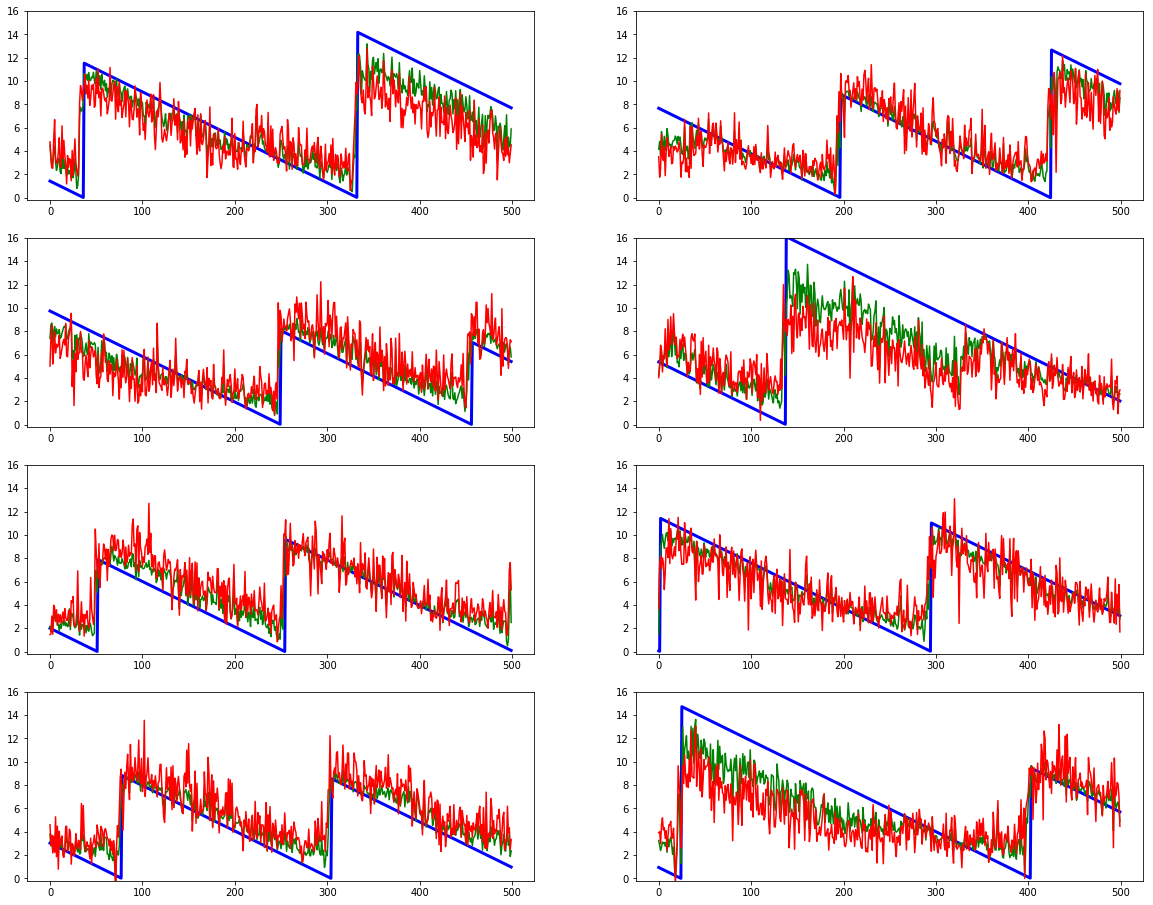

In [55]:
_, ax = plt.subplots(4,2,figsize=(20,16))
ax = ax.reshape(-1)
num_steps = 500

for i in range(8):
    ax[i].plot(y_train[i*num_steps:i*num_steps+num_steps], color='blue', linewidth=3, label='y_train');
    ax[i].plot(y_tr_pred[i*num_steps:i*num_steps+num_steps], color='g', label='LGB training');
    ax[i].plot(y_oof[i*num_steps:i*num_steps+num_steps], color='r', label='LGB oof');
    ax[i].set_ylim([-0.2, 16])

In [ ]:
submission['time_to_failure'] = predictions
submission.to_csv('submission.csv')